# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [3]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
import os
from groq import Groq

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [4]:
#TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOoo

# Hier wird PDF geladen und der Text in die Variable text gespeichert. 

### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


'High and normal protein diets improve body composi'

"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [5]:
#TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOoo


# Text wird in kleine Stücke (Chunks) unterteilt, da LLMs nur begrenzte Mengen Zeichen verarbeiten können.
# chunk_size ist die anzahl Zeichen in die der Text gesplittet wird
# Overlap ist Anzahl Zeichen aus letztem Chunk die wiederholt wird (für roten Faden)
# Danach wird erstellter splitter auf den Text angewendet und die einzelnen Chunks in der variable chunks gespeichert.

# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [6]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 28
Preview of the first chunk: High and normal protein diets improve body composition and 
glucose control in adults with type 2 diabetes: A randomized 
trial
Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3,


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [7]:
# Neuer Splitter wird definiert der nach Tokens nicht nach Zeichen splittet (viele LLM haben Tokenlimit)
# Tokens = Textbausteine (zb einzlne Wörter / Teilwörter / Buchstaben)
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [8]:
# Splitter wird auf die in Var chunks gespeicherten variablen text (also die vorher erstellten Chunks) angewendet
# Aus zb 300 Token grossem Chunk werden nun 2x 128 und 1x 44 Token grosse
# Vorbereitung für Embeddings
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 120
High and normal protein diets improve body composition and glucose control in adults with type 2 diabetes: A randomized trial Julianne G. Clina1, R. Drew Sayer1,3, Zhaoxing Pan2, Caroline W. Cohen3, Michael T. McDermott4, Victoria A. Catenacci4, Holly R. Wyatt1,5, James O. Hill1 1Department of Nutrition Sciences, University of Alabama at Birmingham 2Department of Pediatrics, University of Colorado Anschutz Medical Campus 3Department of Family and Community Medicine, University of Alabama at Birmingham


In [9]:

# Oben wurde Text in Chunks mit bestimmter Tokengrösse aufgeteilt, um danach Embeddings machen zu können.
# Hier wird nun ein bereits vorhandener Chunk in Tokens angezeigt zur Analyse (wie der Text intern auf Tokenebene aussieht).

# For Schleife: geht durch die ersten 10 Chunks der vorher gesplitteten Texte (enumerate gibt laufende nummer i und text zurück)
# Dann werden alle Chunks tokenisiert (also von Text in Token IDs umgewandelt)
# Padding = Wenn text kürzer wird Padding hinzugefügt dass gleiche Länge
# Truncation = Wenn text länger wird abgeschnitten

#  tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
# Hier werden IDs wieder in Text umgewandelt

# Danach zur Liste tokenized_chunks hinzugefügt und geprintet

model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁High', '▁and', '▁normal', '▁protein', '▁die', 'ts', '▁improve', '▁body', '▁composition', '▁and', '▁gluco', 'se', '▁control', '▁in', '▁adults', '▁with', '▁type', '▁2', '▁diabetes', ':', '▁A', '▁random', 'ized', '▁trial', '▁Julian', 'ne', '▁G', '.', '▁C', 'lina', '1', ',', '▁R', '.', '▁Drew', '▁Say', 'er', '1', ',', '3', ',', '▁Z', 'ha', 'ox', 'ing', '▁Pan', '2', ',', '▁Caroline', '▁W', '.', '▁Cohen', '3', ',', '▁Michael', '▁T', '.', '▁Mc', 'Der', 'm', 'ott', '4', ',', '▁Victoria', '▁A', '.', '▁Cate', 'na', 'cci', '4', ',', '▁Holl', 'y', '▁R', '.', '▁Wy', 'att', '1,5', ',', '▁James', '▁O', '.', '▁Hill', '1', '▁1', 'De', 'part', 'ment', '▁of', '▁Nutrition', '▁Science', 's', ',', '▁University', '▁of', '▁Alabama', '▁at', '▁Birmingham', '▁2', 'De', 'part', 'ment', '▁of', '▁Pediatri', 'cs', ',', '▁University', '▁of', '▁Colorado', '▁An', 'schutz', '▁Medical', '▁Campus', '▁3', 'De', 'part', 'ment', '▁of', '▁Family', '▁and', '▁Community', '▁Medicine', ',', '▁University', '▁of'

In [10]:
# Selbes wie oben mit einem anderen Tokenizer

model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'High', 'and', 'normal', 'pro', '##te', '##in', 'die', '##ts', 'im', '##pro', '##ve', 'bo', '##dy', 'comp', '##osition', 'and', 'gl', '##uc', '##ose', 'con', '##trol', 'in', 'ad', '##ult', '##s', 'with', 'type', '2', 'di', '##abet', '##es', ':', 'A', 'ran', '##dom', '##ized', 'tri', '##al', 'Julian', '##ne', 'G', '.', 'Clin', '##a', '##1', ',', 'R', '.', 'Dre', '##w', 'Say', '##er', '##1', ',', '3', ',', 'Z', '##ha', '##ox', '##ing', 'Pan', '##2', ',', 'Caroline', 'W', '.', 'Cohen', '##3', ',', 'Michael', 'T', '.', 'Mc', '##Der', '##mo', '##tt', '##4', ',', 'Victoria', 'A', '.', 'Cat', '##ena', '##cc', '##i', '##4', ',', 'Holly', 'R', '.', 'Wy', '##att', '##1', ',', '5', ',', 'James', 'O', '.', 'Hill', '##1', '1', '##De', '##partment', 'of', 'Nut', '##rit', '##ion', 'Sciences', ',', 'University', 'of', 'Ala', '##ba', '##ma', 'at', 'Birmingham', '2', '##De', '##partment', 'of', 'Ped', '##iat', '##ric', '##s', ',', '[SEP]']
Chunk 1: ['[CLS]', '4', '##Division', 'of', '

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [11]:
#Embedding = mathematischer Vektor, der die Bedeutung eines Textes darstellt. Ähnliche Inhalte → ähnliche Vektoren.
# Embedding-Modell = ML-Modell, das gelernt hat, ähnliche Texte in ähnliche Vektoren zu übersetzen.
# Ich lade ein vortrainiertes Modell und lasse es meine Text-Chunks in Vektoren umwandeln.
# Stellt ein User eine Frage, wird auch diese in einen Vektor umgewandelt – und der inhaltlich passendste Chunk wird über Vektor-Ähnlichkeit gefunden.


# Hier wird für spätere Verwendung ein LangChain-kompatibles Embedding-Objekt erstellt. Ist wie ein Wrapper dass LangChain weiss wie es Embeddings erstellen soll.
# Brauche ich später wenn ich mit LangChain eine Vektor Datenbank füllen will.
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")

# Hier verwende ich das weiter oben bereits zur Analyse geladene Modell und gebe ihm meine erstellten Chunks
# Diese werden in Vektoren umgerechnet und als npArray gespeichert in Variable chunk_embeddings
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

/tmp/ipykernel_71807/3041141898.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [12]:
# Vektorenlänge für FAISS speichern und printen
#
# Vorher erstellte Variable ist ein 2D npArray (Matrix) 
# Zeile ist ein einzelner Vektor
# Spalte die Dimension eines Vektors
# Shape 1 gibt die Anzahl Spalten also die Länge des Vektors aus.
# Diesen Wert brauche ich danach für die FAISS-Vektor Datenbank
d = chunk_embeddings.shape[1]
print(d)

1024


In [13]:
# FAISS Datenbank erstellen mit d Anzahl Dimensionen pro Embedding (vorher gespeicherte Vektorenlänge)
# IndexFlatL2 = Vektoren werden Flach (nicht als Tree oä) gepsichert
# Es wird später mit L2-Distanz nach ähnlichen Vektoren gesucht

# Meine vorher erstellten Embedding Vektoren werden eingefügt.

index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 120


In [14]:
# FAISS Datenbank unter angegebenem Pfad speichern (vorher entsprechenden Ordner erstellen)
faiss.write_index(index, "faiss/faiss_index.index")

# Meine Text-Chunks ebenfalls speichern
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(token_split_texts, f)

In [15]:
# DB und Chunks laden 

index = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts = pickle.load(f)
print(len(token_split_texts))

120


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [16]:
# UMAP um die hochdimensionalen Vektoren auf 2 Dimensionen zu reduzieren, sodass ich sie visualisieren kann.
# UMAP wird trainiert zu erkennen welche Vektoren im hochdimensionalen Raum nah bei einander liegen, sodass sie dann
# auch im 2D Raum nahe sind.
# random_state und transform_seed sorgen dafür, dass du bei erneutem Ausführen die gleiche Projektion bekommst (für Reproduzierbarkeit)


# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

# Funktion die ich später aufrufen kann um embeddings mit dem oben trainierten UMAP (Input der Funktion) in 2D zu Transformieren  
def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
# Hier wende ich dann die oben definierte Funktionn an um meine chunk_embeddings zu transformieren
# Shape printet die neuen Dimensionen (also alte Anzahl embeddings und nur noch 2D)

# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   1%|          | 1/120 [00:02<04:21,  2.20s/it]/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/pyt

Projected dataset embeddings shape: (120, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [18]:
# Funktion um ähnlichste Text Chunks für Benutzereingabe zu finden


def retrieve(query, k):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    #Query aus Function Input wird mit weiter oben trainiertem Mofell in Embedding (Vektor) umgewandelt.
    #Das trainierte Modell versucht Bedeutung der Anfrage in Vektor zu erfassen, sodass es mit bereits berechneten embeddings verglichen werden kann.
    query_embedding = model.encode([query], convert_to_numpy=True)
    #Faiss-Index der die bereits berechneten Embeddings der Text-Chunks enthält wird genutzt, um nach den k (Funktion Input) ähnlihchsten Chunks zum Query zu suchen.
    # Distances gibt Distanz pro Index zurück und indices die Text-Chunks aus dem Faiss Index: je niedriger desto ähnlicher
    distances, indices = index.search(query_embedding, k)
    # Hier werden die Text-Chunks anhand der Indizes aus den indices des FAISS-Indexes abgerufen
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    # Auch die zu den Text-Chunks gehörenden embeddings werden zurückgegeben
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances

In [19]:
# Hier kann nun das query eingefügt werden
# Dann werden die Variabeln für die Resultate instanziert und mit der oben definierten Funktionsaufruf abgefüllt

query = "Does red meat consumption affect weight loss or glucose control in people with type 2 diabetes?"
results, result_embeddings, distances = retrieve(query, 3)
print("Retrieved document preview:")
print(results[0][:300])
print(results[1])

Retrieved document preview:
. Author manuscript; available in PMC 2024 August 01. Author Manuscript Author Manuscript Author Manuscript Author Manuscript What is already known about this subject? • Weight loss of ≥10% improves can improve glucose control and even remit type 2 diabetes for some • High protein diets can produce 
4Division of Endocrinology, Metabolism and Diabetes, University of Colorado School of Medicine, Aurora, Colorado 5Anschutz Health and Wellness Center, University of Colorado Anschutz Medical Campus Abstract Objective: Weight loss of ≥10% improves glucose control and may remit type 2 diabetes (T2D). High protein (HP) diets are commonly used for weight loss, but whether protein sources, especially red meat, impact weight loss-induced T2D management is unknown. This trial compared a HP diet including red meat and normal protein (NP) without red meat for


In [ ]:
# Hier wird meine UMAP Funktion angewendet um mein trainiertes UMAP Modell anzuwenden und in 2D Raum zu transformieren
# 1. Auf die k besten Matches
# 2. Query ebenfalls
# 3. Dann noch das ganze Dataset meiner chunk_embeddings

# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

# embed the embeddings of the entire dataset
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)


Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/12

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

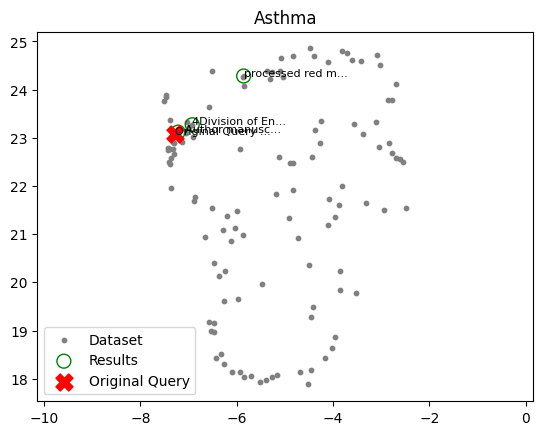

In [ ]:
# Die in 2D transformierten 3 Datenkategorien von oben kann ich nun da plotten und die Distanzen visuell anschauen


#Damit die Labels im Plot nicht zu lang werden, wird jeder Text nach 15 Zeichen abgeschnitten. und ...
def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Asthma')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system

In [22]:
#TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOoo



load_dotenv()
# Access the API key using the variable name defined in the .env file
google_api_key = os.getenv("GOOGLE_API_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

In [ ]:
#TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOoo

# Die Retrive Funktion wo nach den zum Query ähnlichsten Textstellen gesucht wird, wird hier nochmals neu definiert.
# Unterschied: Die andere Funktion verwendet die globalen Variablen index, modell etc. Hier werden sie im Function Input übergeben
# Ist somit flexibler für wiederverwendbarkeit wenn globale Variablen nicht vorhanden sind


def retrieve_texts(query, k, index, token_split_texts, model):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    return retrieved_texts, distances

In [ ]:

#TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOoo

# Funktion die Frage entgegennimmt, passende Textteile aus Dokumentenspeicher heraussucht dies an LLM weiterleitet und antwort generiert.



def answer_query(query, k, index,texts):
    """
    Retrieve the top k similar text chunks for the given query using the retriever,
    inject them into a prompt, and send it to the Groq LLM to obtain an answer.
    
    Parameters:
    - query (str): The user's query.
    - k (int): Number of retrieved documents to use.
    - groq_api_key (str): Your Groq API key.
    
    Returns:
    - answer (str): The answer generated by the LLM.
    """


    model_name = "Sahajtomar/German-semantic"
    model = SentenceTransformer(model_name)

    # Mit Frage nach den ähnlichsten Textstücken suchen mit neuem oben definierten Modell.
    retrieved_texts, _ = retrieve_texts(query, k, index, texts, model)
    
    #Alle gefundenen Textteile in einen Block bringen mit 2 Zeilenumbrüchen dazwischen
    # Combine the retrieved documents into a single context block.
    context = "\n\n".join(retrieved_texts)
    
    # Build a prompt that instructs the LLM to answer the query based on the context.
    prompt = (
        "Answer the following question using the provided context. "
        "Explain it as if you are explaining it to a 5 year old.\n\n"
        "Context:\n" + context + "\n\n"
        "Question: " + query + "\n"
        "Answer:"
    )
    
    # Verbindung zum Groq aufbauen und den Prompt in der "Anweisungsrolle" senden
    # Initialize the Groq client and send the prompt.
    client = Groq(api_key=groq_api_key)
    messages = [
        {
            "role": "system",
            "content": prompt
        }
    ]
    
    llm = client.chat.completions.create(
        messages=messages,
        model="llama-3.3-70b-versatile"
    )
    
    # Extract and return the answer.
    answer = llm.choices[0].message.content
    return answer

: 

In [ ]:
#TODOOOOOOOOOOOOOOOOOOOOOOOOOOOOOoo

# Oben definierte Funktion mit einem Query ausführen und 5 passendste Textstellen an LLM übergeben

query = "What is the most important factor in diagnosing asthma?"
answer = answer_query(query, 5, index, token_split_texts)
print("LLM Answer:", answer)